## Data Collection

Requesting data from the Austin Animal Center API using requests.get

Both datasets contain around 160,000 rows of data. To retrieve all the data, using ```?$limit=160000``` at the end of both API endpoints

### Requesting data from the intake API and storing as a JSON

In [2]:
import requests
import pandas as pd

response = requests.get('https://data.austintexas.gov/resource/wter-evkm.json?$limit=160000')
data_set1 = response.json()
data_set1

[{'animal_id': 'A665644',
  'datetime': '2013-10-21T07:59:00.000',
  'datetime2': '2013-10-21T07:59:00.000',
  'found_location': 'Austin (TX)',
  'intake_type': 'Stray',
  'intake_condition': 'Sick',
  'animal_type': 'Cat',
  'sex_upon_intake': 'Intact Female',
  'age_upon_intake': '4 weeks',
  'breed': 'Domestic Shorthair Mix',
  'color': 'Calico'},
 {'animal_id': 'A665739',
  'name': '*Alana',
  'datetime': '2013-10-22T11:11:00.000',
  'datetime2': '2013-10-22T11:11:00.000',
  'found_location': 'Austin (TX)',
  'intake_type': 'Stray',
  'intake_condition': 'Normal',
  'animal_type': 'Cat',
  'sex_upon_intake': 'Intact Female',
  'age_upon_intake': '1 month',
  'breed': 'Domestic Medium Hair Mix',
  'color': 'Black'},
 {'animal_id': 'A665763',
  'datetime': '2013-10-22T15:10:00.000',
  'datetime2': '2013-10-22T15:10:00.000',
  'found_location': 'E Riverside Dr/Royal Crest Dr in Austin (TX)',
  'intake_type': 'Stray',
  'intake_condition': 'Normal',
  'animal_type': 'Dog',
  'sex_upon_

### Requesting data from the outcome API and storing as a JSON

In [3]:
response2 = requests.get('https://data.austintexas.gov/resource/9t4d-g238.json?$limit=160000')
data_set2 = response2.json()
data_set2

[{'animal_id': 'A794011',
  'name': 'Chunk',
  'datetime': '2019-05-08T18:20:00.000',
  'monthyear': '2019-05-08T18:20:00.000',
  'date_of_birth': '2017-05-02T00:00:00.000',
  'outcome_type': 'Rto-Adopt',
  'animal_type': 'Cat',
  'sex_upon_outcome': 'Neutered Male',
  'age_upon_outcome': '2 years',
  'breed': 'Domestic Shorthair Mix',
  'color': 'Brown Tabby/White'},
 {'animal_id': 'A776359',
  'name': 'Gizmo',
  'datetime': '2018-07-18T16:02:00.000',
  'monthyear': '2018-07-18T16:02:00.000',
  'date_of_birth': '2017-07-12T00:00:00.000',
  'outcome_type': 'Adoption',
  'animal_type': 'Dog',
  'sex_upon_outcome': 'Neutered Male',
  'age_upon_outcome': '1 year',
  'breed': 'Chihuahua Shorthair Mix',
  'color': 'White/Brown'},
 {'animal_id': 'A821648',
  'datetime': '2020-08-16T11:38:00.000',
  'monthyear': '2020-08-16T11:38:00.000',
  'date_of_birth': '2019-08-16T00:00:00.000',
  'outcome_type': 'Euthanasia',
  'animal_type': 'Other',
  'sex_upon_outcome': 'Unknown',
  'age_upon_outcome

### Converting JSON data to a dataframe using PANDAS

In [4]:
# dataframe(df) for intake data
animal_intake_df = pd.DataFrame(data_set1)

# only showing the first 5 rows - can remove .head() to see more rows
animal_intake_df.head(5)


,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name
0,A665644,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,NaN
1,A665739,2013-10-22T11:11:00.000,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,*Alana
2,A665763,2013-10-22T15:10:00.000,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,NaN
3,A379998,2013-10-23T11:42:00.000,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black,Disciple
4,A634503,2013-10-01T14:49:00.000,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,Otter


In [5]:
# dataframe(df) for outcomes data

animal_outcome_df = pd.DataFrame(data_set2)

animal_outcome_df.head(5)


,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
0,A794011,Chunk,2019-05-08T18:20:00.000,2019-05-08T18:20:00.000,2017-05-02T00:00:00.000,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,NaN
1,A776359,Gizmo,2018-07-18T16:02:00.000,2018-07-18T16:02:00.000,2017-07-12T00:00:00.000,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,NaN
2,A821648,NaN,2020-08-16T11:38:00.000,2020-08-16T11:38:00.000,2019-08-16T00:00:00.000,Euthanasia,Other,Unknown,1 year,Raccoon,Gray,NaN
3,A720371,Moose,2016-02-13T17:59:00.000,2016-02-13T17:59:00.000,2015-10-08T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,NaN
4,A674754,NaN,2014-03-18T11:47:00.000,2014-03-18T11:47:00.000,2014-03-12T00:00:00.000,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Partner


### Writing datasets to csv files

In [6]:
# write intake data to csv
animal_intake_df.to_csv("animal_intake_dataset.csv")

# write outcome data to csv
animal_outcome_df.to_csv("animal_outcome_dataset.csv")


## Cleaning the intake dataset

In [7]:
# checking the datatypes of the columns
animal_intake_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154145 entries, 0 to 154144
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         154145 non-null  object
 1   datetime          154145 non-null  object
 2   datetime2         154145 non-null  object
 3   found_location    154145 non-null  object
 4   intake_type       154145 non-null  object
 5   intake_condition  154145 non-null  object
 6   animal_type       154145 non-null  object
 7   sex_upon_intake   154145 non-null  object
 8   age_upon_intake   154145 non-null  object
 9   breed             154145 non-null  object
 10  color             154145 non-null  object
 11  name              109606 non-null  object
dtypes: object(12)
memory usage: 14.1+ MB


### Identifying rows with duplicate values in the animal_id and datetime columns in the intakes:

In [8]:
# Identify duplicate rows based on the 'animal_id' and 'datetime' columns:
duplicates_intakes = animal_intake_df[animal_intake_df.duplicated(subset=['animal_id', 'datetime', 'datetime2'], keep=False)]

duplicates_intakes_sorted = duplicates_intakes.sort_values(by=['animal_id', 'datetime'])

### Converting the result into a dataframe and printing the result to observe the duplicates:

In [9]:
duplicate_intakes_df = pd.DataFrame(duplicates_intakes_sorted)
duplicate_intakes_df.head(20)

,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name
19349,A561806,2017-06-05T11:36:00.000,2017-06-05T11:36:00.000,2002 Nightview in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,Pit Bull Mix,Brown Brindle/White,Dasia
19350,A561806,2017-06-05T11:36:00.000,2017-06-05T11:36:00.000,2002 Nightview in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,Pit Bull Mix,Brown Brindle/White,Dasia
68954,A668183,2014-06-27T11:34:00.000,2014-06-27T11:34:00.000,Austin (TX),Public Assist,Normal,Dog,Spayed Female,10 months,Dachshund Mix,Black/White,Nacha
68955,A668183,2014-06-27T11:34:00.000,2014-06-27T11:34:00.000,Austin (TX),Public Assist,Normal,Dog,Spayed Female,10 months,Dachshund Mix,Black/White,Nacha
99604,A672744,2014-02-17T17:10:00.000,2014-02-17T17:10:00.000,Austin (TX),Public Assist,Normal,Dog,Intact Male,3 years,Rottweiler Mix,Black/Tan,Oso
128943,A672744,2014-02-17T17:10:00.000,2014-02-17T17:10:00.000,Travis (TX),Owner Surrender,Normal,Dog,Intact Male,3 years,Rottweiler Mix,Black/Tan,Oso
70311,A681446,2014-06-16T16:38:00.000,2014-06-16T16:38:00.000,6208 Tupelo Dr in Austin (TX),Wildlife,Normal,Other,Unknown,1 year,Bat,Brown,NaN
70312,A681446,2014-06-16T16:38:00.000,2014-06-16T16:38:00.000,6208 Tupelo Dr in Austin (TX),Wildlife,Normal,Other,Unknown,1 year,Bat,Brown,NaN
74983,A695798,2015-01-23T11:48:00.000,2015-01-23T11:48:00.000,Austin (TX),Owner Surrender,Sick,Cat,Neutered Male,10 months,Domestic Shorthair Mix,Orange,Jim
74984,A695798,2015-01-23T11:48:00.000,2015-01-23T11:48:00.000,Austin (TX),Owner Surrender,Sick,Cat,Neutered Male,10 months,Domestic Shorthair Mix,Orange,Jim


### Removing duplicate rows from the intakes df

Removing duplicate rows where the animal_id and datetime values are the same.
Where they are the same, this means the data was inputted twice (probably by mistake) and so removing these duplicate values will ensure the results are not skewed.

In [10]:
# show key features-based duplicates with identical animal_id, datetime, datetime2 (except for first occurrence)
animal_intake_df[animal_intake_df[["animal_id", "datetime", "datetime2"]].duplicated()]

,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name
6102,A830075,2021-03-02T13:35:00.000,2021-03-02T13:35:00.000,Onion Creek And Pleasant Valley in Austin (TX),Stray,Normal,Dog,Intact Male,1 year,Chihuahua Shorthair Mix,Tan,Waffle
8264,A696688,2015-02-10T11:00:00.000,2015-02-10T11:00:00.000,Austin (TX),Owner Surrender,Normal,Cat,Spayed Female,3 years,Domestic Shorthair Mix,Calico/White,Mari
10453,A727043,2016-05-17T15:46:00.000,2016-05-17T15:46:00.000,9515 N Lamar Blvd in Austin (TX),Stray,Normal,Cat,Intact Male,1 year,Domestic Shorthair Mix,Blue/White,*Larry
14420,A866229,2022-09-26T15:17:00.000,2022-09-26T15:17:00.000,9301 Hog Eye Rd in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Shorthair,Orange Tabby,*Jones
15127,A761936,2017-11-12T11:16:00.000,2017-11-12T11:16:00.000,8400 Old Bee Caves in Austin (TX),Stray,Normal,Dog,Intact Male,9 months,Scottish Terrier Mix,Brown Brindle,NaN
16486,A863452,2022-08-31T11:55:00.000,2022-08-31T11:55:00.000,4200 Brookview in Austin (TX),Stray,Normal,Dog,Intact Female,10 months,German Shepherd,White,Amber
19350,A561806,2017-06-05T11:36:00.000,2017-06-05T11:36:00.000,2002 Nightview in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,Pit Bull Mix,Brown Brindle/White,Dasia
31560,A773428,2018-05-31T18:38:00.000,2018-05-31T18:38:00.000,7Th And Gonzalez in Austin (TX),Stray,Normal,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Orange Tabby,*Atreyu
50922,A815987,2020-04-09T15:32:00.000,2020-04-09T15:32:00.000,Austin (TX),Public Assist,Normal,Dog,Intact Female,1 year,Cairn Terrier,White/Brown,Princess
54850,A735395,2016-09-23T12:00:00.000,2016-09-23T12:00:00.000,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,10 months,Domestic Shorthair Mix,Brown Tabby,Owl


In [11]:
# delete duplicates and save changes to existing dataframe
animal_intake_df.drop_duplicates(subset=['animal_id', 'datetime', 'datetime2'], inplace=True)
animal_intake_df

,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name
0,A665644,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,NaN
1,A665739,2013-10-22T11:11:00.000,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,*Alana
2,A665763,2013-10-22T15:10:00.000,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,NaN
3,A379998,2013-10-23T11:42:00.000,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black,Disciple
4,A634503,2013-10-01T14:49:00.000,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,Otter
...,...,...,...,...,...,...,...,...,...,...,...,...
154140,A886540,2023-08-07T15:14:00.000,2023-08-07T15:14:00.000,8300 North Interstate Highway 35 in Austin (TX),Stray,Normal,Dog,Intact Male,2 years,Parson Russell Terrier,White/Tan,A886540
154141,A886551,2023-08-07T17:54:00.000,2023-08-07T17:54:00.000,3801 North Capital Of Texas Highway in Austin ...,Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,White/Blue,A886551
154142,A886552,2023-08-07T17:54:00.000,2023-08-07T17:54:00.000,3801 North Capital Of Texas Highway in Austin ...,Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Blue,A886552
154143,A885031,2023-08-07T14:05:00.000,2023-08-07T14:05:00.000,11901 Pavilion in Austin (TX),Owner Surrender,Sick,Dog,Intact Female,2 years,Pit Bull Mix,Tan/White,Diamond


### Removing duplicate columns from the intakes df

The dataset contains two seemingly identical columns for datetime of intake: datetime and datetime2. Confirm that these are in fact duplicates, then delete duplicate columns and replace with a more appropriately named intake_date column.

In [12]:
# checking to ensure datetime and datetime2 are identical for all records
animal_intake_df[~(animal_intake_df["datetime"] == animal_intake_df["datetime2"])]

,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name


In [13]:
# storing the datetime column data into a variable intake_date
intake_date = animal_intake_df['datetime']

# using the PANDAS drop function to drop the 'datetime' and 'datetime2' columns from the intake dataset
intake_df = animal_intake_df.drop(['datetime', 'datetime2'], axis='columns')

# inserting the new column which we created above (intake_date) and placing this at index 1 in the dataframe
intake_df.insert(1, 'intake_date', intake_date)

intake_df.shape


(154112, 11)

## Cleaning the outcome dataset

Repeat the process that was completed above in the intakes df for the outcomes dataset

### Removing duplicate rows from the outcome df

Removing duplicate rows where the animal_id and datetime values are the same.
Where they are the same, this means the data was inputted twice (probably by mistake) and so removing these duplicate values will ensure the results are not skewed.

In [14]:
# show key features-based duplicates with identical animal_id, datetime, monthyear (except for first occurrence)
animal_outcome_df[animal_outcome_df[["animal_id", "datetime", "monthyear"]].duplicated()]

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
9765,A815987,Princess,2020-04-13T16:56:00.000,2020-04-13T16:56:00.000,2019-04-02T00:00:00.000,Return to Owner,Dog,Intact Female,1 year,Cairn Terrier,White/Brown,NaN
18142,A761936,NaN,2017-11-16T12:54:00.000,2017-11-16T12:54:00.000,2017-01-12T00:00:00.000,Transfer,Dog,Intact Male,10 months,Scottish Terrier Mix,Brown Brindle,Partner
25844,A783234,Princess,2019-01-13T16:39:00.000,2019-01-13T16:39:00.000,2016-10-27T00:00:00.000,Rto-Adopt,Dog,Spayed Female,2 years,Collie Smooth/Pointer,Brown,NaN
40086,A846569,A846569,2021-12-04T10:34:00.000,2021-12-04T10:34:00.000,2021-06-15T00:00:00.000,Adoption,Dog,Neutered Male,5 months,Australian Cattle Dog Mix,Red Tick,NaN
54716,A682781,NaN,2014-07-03T09:00:00.000,2014-07-03T09:00:00.000,2013-01-02T00:00:00.000,Transfer,Cat,Neutered Male,1 year,Domestic Shorthair Mix,White/Black,SCRP
60904,A683782,NaN,2014-07-16T09:00:00.000,2014-07-16T09:00:00.000,2014-02-15T00:00:00.000,Transfer,Cat,Neutered Male,4 months,Domestic Shorthair Mix,Brown Tabby,SCRP
69429,A686827,NaN,2014-08-28T09:00:00.000,2014-08-28T09:00:00.000,2012-02-27T00:00:00.000,Transfer,Cat,Spayed Female,2 years,Domestic Shorthair Mix,Calico,SCRP
80201,A755687,NaN,2017-08-07T13:50:00.000,2017-08-07T13:50:00.000,2014-08-07T00:00:00.000,Disposal,Other,Unknown,3 years,Bat Mix,Brown,NaN
81730,A660948,*Roy,2013-11-03T18:16:00.000,2013-11-03T18:16:00.000,2013-07-08T00:00:00.000,Adoption,Cat,Neutered Male,3 months,Domestic Shorthair Mix,Brown Tabby/White,NaN
90540,A866229,*Jones,2022-10-29T11:16:00.000,2022-10-29T11:16:00.000,2022-08-07T00:00:00.000,Adoption,Cat,Neutered Male,2 months,Domestic Shorthair,Orange Tabby,NaN


In [15]:
# delete duplicates and save changes to existing dataframe
animal_outcome_df.drop_duplicates(subset=['animal_id', 'datetime', 'monthyear'], inplace=True)
animal_outcome_df

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
0,A794011,Chunk,2019-05-08T18:20:00.000,2019-05-08T18:20:00.000,2017-05-02T00:00:00.000,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,NaN
1,A776359,Gizmo,2018-07-18T16:02:00.000,2018-07-18T16:02:00.000,2017-07-12T00:00:00.000,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,NaN
2,A821648,NaN,2020-08-16T11:38:00.000,2020-08-16T11:38:00.000,2019-08-16T00:00:00.000,Euthanasia,Other,Unknown,1 year,Raccoon,Gray,NaN
3,A720371,Moose,2016-02-13T17:59:00.000,2016-02-13T17:59:00.000,2015-10-08T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,NaN
4,A674754,NaN,2014-03-18T11:47:00.000,2014-03-18T11:47:00.000,2014-03-12T00:00:00.000,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Partner
...,...,...,...,...,...,...,...,...,...,...,...,...
154064,A859974,*Lady Gaga,2022-08-16T11:42:00.000,2022-08-16T11:42:00.000,2012-06-21T00:00:00.000,Adoption,Cat,Spayed Female,10 years,Devon Rex,White,NaN
154065,A856973,*Suede,2022-06-11T15:39:00.000,2022-06-11T15:39:00.000,2021-05-10T00:00:00.000,Adoption,Cat,Spayed Female,1 year,Domestic Medium Hair,Blue,NaN
154066,A852036,Queen,2022-03-17T17:22:00.000,2022-03-17T17:22:00.000,2021-12-08T00:00:00.000,Adoption,Dog,Spayed Female,3 months,German Shepherd Mix,Brown/Black,NaN
154067,A852775,A852775,2022-05-18T14:13:00.000,2022-05-18T14:13:00.000,2022-01-31T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Tortie,Foster


### Removing duplicate columns from the outcomes df

The dataset contains two seemingly identical columns for datetime of intake: datetime and monthyear. Confirm that these are in fact duplicates, then delete duplicate columns and replace with a more appropriately named intake_date column.

In [16]:
# checking to ensure datetime and monthyear are identical for all records
animal_outcome_df[~(animal_outcome_df["datetime"] == animal_outcome_df["monthyear"])]

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype


In [17]:
# storing the datetime column data into a variable outcome date
outcome_date = animal_outcome_df['datetime']

# using the PANDAS drop function to drop the 'datetime' and 'monthyear' columns from the outcome dataset
outcome_df = animal_outcome_df.drop(['datetime', 'monthyear'], axis='columns')

# inserting the new column which we created above (outcome_date) and placing this at index 1 in the dataframe
outcome_df.insert(1, 'outcome_date', outcome_date)

outcome_df.shape

(154047, 11)

## Merging intake and outcome dataframes

For ease of analysis, the outcome and intake dataframes are merged. We choose to perform an inner join on animal_id to limit the data that we work with to those animals where there is information about both their intake and their ultimate outcome.

In [18]:
# merging dataframes based on animal_id
shelter_df = pd.merge(intake_df, outcome_df, how='inner', on='animal_id', suffixes=['_outcomes', '_intakes'])

shelter_df


,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype
0,A665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,...,2013-10-21T11:39:00.000,NaN,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,Partner
1,A665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,...,2013-12-20T17:36:00.000,*Alana,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Black,Foster
2,A665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,...,2013-10-26T18:32:00.000,NaN,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Cairn Terrier Mix,Tan/White,NaN
3,A379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black,...,2013-10-25T12:53:00.000,Disciple,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Pit Bull,Black,NaN
4,A634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,...,2013-10-02T12:40:00.000,Otter,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,A886449,2023-08-05T18:08:00.000,5014 Highland Court in Austin (TX),Stray,Neonatal,Cat,Intact Female,1 day,Domestic Shorthair,Black/White,...,2023-08-07T15:04:00.000,NaN,2023-08-04T00:00:00.000,Died,Cat,Intact Female,3 days,Domestic Shorthair,Black/White,In Kennel
197429,A885814,2023-07-25T21:36:00.000,611 Carpenter in Austin (TX),Public Assist,Normal,Dog,Intact Male,1 year,Pit Bull Mix,White/Black,...,2023-08-06T18:53:00.000,George,2021-07-26T00:00:00.000,Return to Owner,Dog,Intact Male,2 years,Pit Bull Mix,White/Black,NaN
197430,A886517,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Dog,Intact Female,2 months,German Shepherd Mix,Black/Brown,...,2023-08-07T17:59:00.000,NaN,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,German Shepherd Mix,Black/Brown,Partner
197431,A886518,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Dog,Intact Female,2 months,German Shepherd Mix,Black/Tan,...,2023-08-07T18:00:00.000,NaN,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,German Shepherd Mix,Black/Tan,Partner


## Cleaning merged dataframe

### Converting animal_id to data type integer

Remove the "A" at the beginning of the animal_id by using regex. We can then turn the animal_id into an integer data type for ease of sorting and manipulation.

In [19]:
# Use of regex to remove the A in animal_id, rather than using string slicing as if the code is run multiple times, then will remove a value each time
shelter_df['animal_id'] = shelter_df['animal_id'].str.replace(r'A', '', regex=True).astype(int)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,...,2013-10-21T11:39:00.000,NaN,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,Partner
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,...,2013-12-20T17:36:00.000,*Alana,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Black,Foster
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,...,2013-10-26T18:32:00.000,NaN,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Cairn Terrier Mix,Tan/White,NaN
3,379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black,...,2013-10-25T12:53:00.000,Disciple,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Pit Bull,Black,NaN
4,634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,...,2013-10-02T12:40:00.000,Otter,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05T18:08:00.000,5014 Highland Court in Austin (TX),Stray,Neonatal,Cat,Intact Female,1 day,Domestic Shorthair,Black/White,...,2023-08-07T15:04:00.000,NaN,2023-08-04T00:00:00.000,Died,Cat,Intact Female,3 days,Domestic Shorthair,Black/White,In Kennel
197429,885814,2023-07-25T21:36:00.000,611 Carpenter in Austin (TX),Public Assist,Normal,Dog,Intact Male,1 year,Pit Bull Mix,White/Black,...,2023-08-06T18:53:00.000,George,2021-07-26T00:00:00.000,Return to Owner,Dog,Intact Male,2 years,Pit Bull Mix,White/Black,NaN
197430,886517,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Dog,Intact Female,2 months,German Shepherd Mix,Black/Brown,...,2023-08-07T17:59:00.000,NaN,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,German Shepherd Mix,Black/Brown,Partner
197431,886518,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Dog,Intact Female,2 months,German Shepherd Mix,Black/Tan,...,2023-08-07T18:00:00.000,NaN,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,German Shepherd Mix,Black/Tan,Partner


### Removing duplicate and unneeded columns

The two datasets had some columns that we thought might contain the exact same data, thereby introducing duplicates upon the merge. We checked these columns to confirm if the data was in fact duplicate, then deleted duplicates accordingly.

In [20]:
# Confirm that color_outcomes and color_intakes are duplicates (result confirms duplication)
shelter_df[~(shelter_df["color_outcomes"] == shelter_df["color_intakes"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype


In [21]:
# Confirm that breed_outcomes and breed_intakes are duplicates (result confirms duplication)
shelter_df[~(shelter_df["breed_outcomes"] == shelter_df["breed_intakes"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype


In [22]:
# Confirm that animal_type_outcomes and animal_type_intakes are duplicates (result confirms duplication)
shelter_df[~(shelter_df["animal_type_outcomes"] == shelter_df["animal_type_intakes"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype


In [23]:
# Cheking if sex_upon_outcome and sex_upon_intake are duplicates (result confirms NOT duplicated)
shelter_df[~(shelter_df["sex_upon_outcome"] == shelter_df["sex_upon_intake"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,...,2013-12-20T17:36:00.000,*Alana,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Black,Foster
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,...,2013-10-26T18:32:00.000,NaN,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Cairn Terrier Mix,Tan/White,NaN
7,664936,2013-10-11T11:20:00.000,501 U.S. 183 in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Medium Hair Mix,Brown Tabby,...,2013-12-18T18:18:00.000,*Jester,2013-08-18T00:00:00.000,Adoption,Cat,Neutered Male,4 months,Domestic Medium Hair Mix,Brown Tabby,NaN
12,664887,2013-10-10T13:48:00.000,1901 Onion Creek Pkwy in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Shorthair Mix,Black,...,2013-11-10T16:56:00.000,*Gia,2013-08-10T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Black,NaN
13,665800,2013-10-23T11:08:00.000,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,3 months,Domestic Shorthair Mix,Tortie,...,2013-11-10T18:50:00.000,*Precious,2013-07-23T00:00:00.000,Transfer,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Tortie,Partner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197394,841865,2021-09-04T12:40:00.000,Parsons Rd in Travis (TX),Stray,Normal,Dog,Intact Female,1 month,American Staffordshire Terrier,Brown Brindle/White,...,2021-10-05T19:03:00.000,Zooza,2021-07-20T00:00:00.000,Adoption,Dog,Spayed Female,2 months,American Staffordshire Terrier,Brown Brindle/White,NaN
197395,841865,2021-09-04T12:40:00.000,Parsons Rd in Travis (TX),Stray,Normal,Dog,Intact Female,1 month,American Staffordshire Terrier,Brown Brindle/White,...,2021-09-11T15:19:00.000,Zooza,2021-07-20T00:00:00.000,Adoption,Dog,Spayed Female,1 month,American Staffordshire Terrier,Brown Brindle/White,NaN
197416,879403,2023-04-25T12:25:00.000,Greenwood Dr And E Hwy 71 in Austin (TX),Stray,Normal,Dog,Intact Male,7 months,German Shepherd Mix,Black/Brown,...,2023-05-04T16:35:00.000,Hagrid,2022-08-25T00:00:00.000,Adoption,Dog,Neutered Male,8 months,German Shepherd Mix,Black/Brown,NaN
197417,879403,2023-04-25T12:25:00.000,Greenwood Dr And E Hwy 71 in Austin (TX),Stray,Normal,Dog,Intact Male,7 months,German Shepherd Mix,Black/Brown,...,2023-05-30T17:41:00.000,Hagrid,2022-08-25T00:00:00.000,Adoption,Dog,Neutered Male,9 months,German Shepherd Mix,Black/Brown,NaN


In [24]:
# Removing duplicate columns
shelter_df.drop(['color_outcomes',
                'breed_intakes',
                'animal_type_outcomes'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,name_outcomes,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,NaN,2013-10-21T11:39:00.000,NaN,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,*Alana,2013-12-20T17:36:00.000,*Alana,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,NaN,2013-10-26T18:32:00.000,NaN,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN
3,379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Intact Male,10 years,Pit Bull,Disciple,2013-10-25T12:53:00.000,Disciple,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Black,NaN
4,634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Spayed Female,2 years,Norfolk Terrier Mix,Otter,2013-10-02T12:40:00.000,Otter,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05T18:08:00.000,5014 Highland Court in Austin (TX),Stray,Neonatal,Intact Female,1 day,Domestic Shorthair,NaN,2023-08-07T15:04:00.000,NaN,2023-08-04T00:00:00.000,Died,Cat,Intact Female,3 days,Black/White,In Kennel
197429,885814,2023-07-25T21:36:00.000,611 Carpenter in Austin (TX),Public Assist,Normal,Intact Male,1 year,Pit Bull Mix,George,2023-08-06T18:53:00.000,George,2021-07-26T00:00:00.000,Return to Owner,Dog,Intact Male,2 years,White/Black,NaN
197430,886517,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Intact Female,2 months,German Shepherd Mix,NaN,2023-08-07T17:59:00.000,NaN,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,Black/Brown,Partner
197431,886518,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Intact Female,2 months,German Shepherd Mix,NaN,2023-08-07T18:00:00.000,NaN,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,Black/Tan,Partner



Separately, there are some columns in the merged dataframe that are not helpful for our analysis. These include name_intakes and name_outcomes and can be removed.

In [25]:
# Removing columns that we do not need for our analysis
shelter_df.drop(['name_intakes',
                'name_outcomes'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN
3,379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Intact Male,10 years,Pit Bull,2013-10-25T12:53:00.000,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Black,NaN
4,634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Spayed Female,2 years,Norfolk Terrier Mix,2013-10-02T12:40:00.000,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05T18:08:00.000,5014 Highland Court in Austin (TX),Stray,Neonatal,Intact Female,1 day,Domestic Shorthair,2023-08-07T15:04:00.000,2023-08-04T00:00:00.000,Died,Cat,Intact Female,3 days,Black/White,In Kennel
197429,885814,2023-07-25T21:36:00.000,611 Carpenter in Austin (TX),Public Assist,Normal,Intact Male,1 year,Pit Bull Mix,2023-08-06T18:53:00.000,2021-07-26T00:00:00.000,Return to Owner,Dog,Intact Male,2 years,White/Black,NaN
197430,886517,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Intact Female,2 months,German Shepherd Mix,2023-08-07T17:59:00.000,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,Black/Brown,Partner
197431,886518,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Intact Female,2 months,German Shepherd Mix,2023-08-07T18:00:00.000,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,Black/Tan,Partner


### Removing whitespaces

The data in our datasets are likely to be input by users. To ensure that leading and trailing whitespaces do not interfere with our analysis, we define a lambda function to remove them using the .apply method.

In [26]:
# look for columns with datatype object and strip any leading/trailing spaces
shelter_df.apply(lambda value: value.str.strip() if value.dtype == "object" else value)

shelter_df.head(3)

,animal_id,intake_date,found_location,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN


## Additional data manipulation to prepare for analysis

We identified several ways that the data needed to be manipulated to prepare it for our analysis.

### 1. Extracting sex and neuter status into separate columns
One of our observations was that the sex_upon_intake and sex_upon_outcome contain the sex of the animal as well as their neuter status. We prepare our data for analysis by seperating sex and neuter status into separate columns for both intake and outcome, then comparing values for sex at both intake and outcome to confirm these are duplicates. Accordingly, we delete one of the sex columns.

In [27]:
# using regex to return values about neuturing into new columns -
# this is done by extracting the word before the white space as can see from the data that there is a space between the neuteruing and gender of animal
shelter_df['Neuter Status at Intake'] = shelter_df['sex_upon_intake'].str.extract('(\w*\s)', expand=True)
shelter_df['Neuter Status at Outcome'] = shelter_df['sex_upon_outcome'].str.extract('(\w*\s)', expand=True)

# using regex to return the sex of the animal at intake and outcome in new columns
shelter_df['Sex at Intake'] = shelter_df['sex_upon_intake'].str.extract(('[^ ]* (.*)'), expand=True)
shelter_df['Sex at Outcome'] = shelter_df['sex_upon_outcome'].str.extract(('[^ ]* (.*)'), expand=True)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Sex at Outcome
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner,Intact,Intact,Female,Female
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster,Intact,Spayed,Female,Female
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN,Intact,Neutered,Male,Male
3,379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Intact Male,10 years,Pit Bull,2013-10-25T12:53:00.000,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Black,NaN,Intact,Intact,Male,Male
4,634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Spayed Female,2 years,Norfolk Terrier Mix,2013-10-02T12:40:00.000,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Tan,NaN,Spayed,Spayed,Female,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05T18:08:00.000,5014 Highland Court in Austin (TX),Stray,Neonatal,Intact Female,1 day,Domestic Shorthair,2023-08-07T15:04:00.000,2023-08-04T00:00:00.000,Died,Cat,Intact Female,3 days,Black/White,In Kennel,Intact,Intact,Female,Female
197429,885814,2023-07-25T21:36:00.000,611 Carpenter in Austin (TX),Public Assist,Normal,Intact Male,1 year,Pit Bull Mix,2023-08-06T18:53:00.000,2021-07-26T00:00:00.000,Return to Owner,Dog,Intact Male,2 years,White/Black,NaN,Intact,Intact,Male,Male
197430,886517,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Intact Female,2 months,German Shepherd Mix,2023-08-07T17:59:00.000,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,Black/Brown,Partner,Intact,Intact,Female,Female
197431,886518,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Intact Female,2 months,German Shepherd Mix,2023-08-07T18:00:00.000,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,Black/Tan,Partner,Intact,Intact,Female,Female


Some values in these new columns are missing, so we replace NaN values with "Unknown"

In [28]:
# adding the string Unknown into as the value for new columns that contain NaN
shelter_df[['Sex at Intake', 'Sex at Outcome', 'Neuter Status at Intake', 'Neuter Status at Outcome']] = shelter_df[['Sex at Intake', 'Sex at Outcome', 'Neuter Status at Intake', 'Neuter Status at Outcome']].fillna('Unknown')

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Sex at Outcome
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner,Intact,Intact,Female,Female
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster,Intact,Spayed,Female,Female
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN,Intact,Neutered,Male,Male
3,379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Intact Male,10 years,Pit Bull,2013-10-25T12:53:00.000,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Black,NaN,Intact,Intact,Male,Male
4,634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Spayed Female,2 years,Norfolk Terrier Mix,2013-10-02T12:40:00.000,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Tan,NaN,Spayed,Spayed,Female,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05T18:08:00.000,5014 Highland Court in Austin (TX),Stray,Neonatal,Intact Female,1 day,Domestic Shorthair,2023-08-07T15:04:00.000,2023-08-04T00:00:00.000,Died,Cat,Intact Female,3 days,Black/White,In Kennel,Intact,Intact,Female,Female
197429,885814,2023-07-25T21:36:00.000,611 Carpenter in Austin (TX),Public Assist,Normal,Intact Male,1 year,Pit Bull Mix,2023-08-06T18:53:00.000,2021-07-26T00:00:00.000,Return to Owner,Dog,Intact Male,2 years,White/Black,NaN,Intact,Intact,Male,Male
197430,886517,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Intact Female,2 months,German Shepherd Mix,2023-08-07T17:59:00.000,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,Black/Brown,Partner,Intact,Intact,Female,Female
197431,886518,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,Intact Female,2 months,German Shepherd Mix,2023-08-07T18:00:00.000,2023-05-30T00:00:00.000,Transfer,Dog,Intact Female,2 months,Black/Tan,Partner,Intact,Intact,Female,Female


In [29]:
# Confirm that sex at intake and sex at outcome are the same for each record (result confirms these columns are duplicates)
shelter_df[~(shelter_df["Sex at Intake"] == shelter_df["Sex at Outcome"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Sex at Outcome


In [30]:
# Delete duplicate column as well as source columns which are no longer needed
shelter_df.drop(['Sex at Outcome',
                'sex_upon_outcome',
                'sex_upon_intake'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,4 weeks,Calico,Partner,Intact,Intact,Female
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,3 months,Black,Foster,Intact,Spayed,Female
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,4 months,Tan/White,NaN,Intact,Neutered,Male
3,379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,10 years,Pit Bull,2013-10-25T12:53:00.000,2003-02-21T00:00:00.000,Return to Owner,Dog,10 years,Black,NaN,Intact,Intact,Male
4,634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02T12:40:00.000,2011-08-11T00:00:00.000,Adoption,Dog,2 years,Tan,NaN,Spayed,Spayed,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05T18:08:00.000,5014 Highland Court in Austin (TX),Stray,Neonatal,1 day,Domestic Shorthair,2023-08-07T15:04:00.000,2023-08-04T00:00:00.000,Died,Cat,3 days,Black/White,In Kennel,Intact,Intact,Female
197429,885814,2023-07-25T21:36:00.000,611 Carpenter in Austin (TX),Public Assist,Normal,1 year,Pit Bull Mix,2023-08-06T18:53:00.000,2021-07-26T00:00:00.000,Return to Owner,Dog,2 years,White/Black,NaN,Intact,Intact,Male
197430,886517,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07T17:59:00.000,2023-05-30T00:00:00.000,Transfer,Dog,2 months,Black/Brown,Partner,Intact,Intact,Female
197431,886518,2023-08-07T11:50:00.000,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07T18:00:00.000,2023-05-30T00:00:00.000,Transfer,Dog,2 months,Black/Tan,Partner,Intact,Intact,Female


### 2. Calculating each animal's length of stay at the shelter

We can find the amount of time each animal spent in the shelter and store this in a new column. For this calculation, we convert the intake_date and outcome_date columns to datetime using the `to_datetime` function, then subtract the outcome date by the intake date.

In [31]:
shelter_df['intake_date'] = pd.to_datetime(shelter_df['intake_date'])
shelter_df['outcome_date'] = pd.to_datetime(shelter_df['outcome_date'])
shelter_df['Time In Shelter'] = shelter_df['outcome_date'] - shelter_df['intake_date']
shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Time In Shelter
0,665644,2013-10-21 07:59:00,Austin (TX),Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21T00:00:00.000,Transfer,Cat,4 weeks,Calico,Partner,Intact,Intact,Female,0 days 03:40:00
1,665739,2013-10-22 11:11:00,Austin (TX),Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16T00:00:00.000,Adoption,Cat,3 months,Black,Foster,Intact,Spayed,Female,59 days 06:25:00
2,665763,2013-10-22 15:10:00,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22T00:00:00.000,Adoption,Dog,4 months,Tan/White,NaN,Intact,Neutered,Male,4 days 03:22:00
3,379998,2013-10-23 11:42:00,51St And Grover in Austin (TX),Stray,Normal,10 years,Pit Bull,2013-10-25 12:53:00,2003-02-21T00:00:00.000,Return to Owner,Dog,10 years,Black,NaN,Intact,Intact,Male,2 days 01:11:00
4,634503,2013-10-01 14:49:00,Manor (TX),Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11T00:00:00.000,Adoption,Dog,2 years,Tan,NaN,Spayed,Spayed,Female,0 days 21:51:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05 18:08:00,5014 Highland Court in Austin (TX),Stray,Neonatal,1 day,Domestic Shorthair,2023-08-07 15:04:00,2023-08-04T00:00:00.000,Died,Cat,3 days,Black/White,In Kennel,Intact,Intact,Female,1 days 20:56:00
197429,885814,2023-07-25 21:36:00,611 Carpenter in Austin (TX),Public Assist,Normal,1 year,Pit Bull Mix,2023-08-06 18:53:00,2021-07-26T00:00:00.000,Return to Owner,Dog,2 years,White/Black,NaN,Intact,Intact,Male,11 days 21:17:00
197430,886517,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07 17:59:00,2023-05-30T00:00:00.000,Transfer,Dog,2 months,Black/Brown,Partner,Intact,Intact,Female,0 days 06:09:00
197431,886518,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07 18:00:00,2023-05-30T00:00:00.000,Transfer,Dog,2 months,Black/Tan,Partner,Intact,Intact,Female,0 days 06:10:00


We can now get a sense of the distribution in our data by using the describe function.


In [32]:
shelter_df.describe()

,animal_id,Time In Shelter
count,197433.000000,197433
mean,754873.424934,19 days 06:19:39.545060856
std,69722.684065,283 days 20:54:09.746166552
min,6100.000000,-3536 days +06:54:00
25%,705471.000000,0 days 21:06:00
50%,753274.000000,5 days 07:10:00
75%,805072.000000,26 days 08:10:00
max,886518.000000,3550 days 22:05:00


This shows the minimum time in shelter is negative. Where the time in shelter is negative, the intake date is more recent then the outcome date. We check for records where the intake date is after the outcome date.

In [33]:
# check for occurrences where intake date is after outcome date (suggesting data input error)
incorrect_dates = shelter_df[shelter_df['intake_date'] >= shelter_df['outcome_date']]

incorrect_dates

,animal_id,intake_date,found_location,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Time In Shelter
16,645345,2018-05-12 14:07:00,Austin (TX),Owner Surrender,Normal,6 years,Pit Bull Mix,2013-10-20 16:29:00,2012-01-06T00:00:00.000,Transfer,Dog,1 year,Brown/White,Partner,Spayed,Spayed,Female,-1665 days +02:22:00
26,665923,2016-07-16 18:07:00,Austin (TX),Public Assist,Normal,4 years,German Shepherd/Labrador Retriever,2013-11-04 15:00:00,2012-04-24T00:00:00.000,Return to Owner,Dog,1 year,Red,NaN,Spayed,Spayed,Female,-986 days +20:53:00
44,664439,2013-12-16 14:07:00,51St And Overbrook in Austin (TX),Stray,Normal,6 months,Dachshund/Rat Terrier,2013-10-10 16:39:00,2013-06-03T00:00:00.000,Adoption,Dog,4 months,White/Black,NaN,Neutered,Neutered,Male,-67 days +02:32:00
56,665874,2014-01-12 08:30:00,4434 Frontier in Austin (TX),Stray,Normal,11 months,Pit Bull Mix,2013-10-24 14:30:00,2013-01-13T00:00:00.000,Return to Owner,Dog,9 months,Brown/White,NaN,Neutered,Neutered,Male,-80 days +06:00:00
57,665874,2016-11-09 12:01:00,8721 Escabosa Dr in Austin (TX),Stray,Normal,3 years,Pit Bull Mix,2014-01-13 12:40:00,2013-01-13T00:00:00.000,Return to Owner,Dog,1 year,Brown/White,NaN,Neutered,Neutered,Male,-1031 days +00:39:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197401,875525,2023-07-23 21:47:00,12200 Jourdan Crossing in Austin (TX),Public Assist,Normal,8 months,Domestic Shorthair,2023-03-07 17:31:00,2022-11-16T00:00:00.000,Return to Owner,Cat,3 months,Black,NaN,Intact,Intact,Male,-139 days +19:44:00
197414,879403,2023-05-23 16:32:00,Austin (TX),Owner Surrender,Normal,8 months,German Shepherd Mix,2023-05-04 16:35:00,2022-08-25T00:00:00.000,Adoption,Dog,8 months,Black/Brown,NaN,Neutered,Neutered,Male,-19 days +00:03:00
197418,879403,2023-08-05 23:40:00,Austin (TX),Owner Surrender,Normal,11 months,German Shepherd Mix,2023-05-04 16:35:00,2022-08-25T00:00:00.000,Adoption,Dog,8 months,Black/Brown,NaN,Neutered,Neutered,Male,-94 days +16:55:00
197419,879403,2023-08-05 23:40:00,Austin (TX),Owner Surrender,Normal,11 months,German Shepherd Mix,2023-05-30 17:41:00,2022-08-25T00:00:00.000,Adoption,Dog,9 months,Black/Brown,NaN,Neutered,Neutered,Male,-68 days +18:01:00


There are a considerable number of rows with this discrepancy. Because these inaccuracies could skew our analysis, we choose to remove these records.

In [34]:
# Using .index, we remove the rows by the index of the incorrect date rows
shelter_df.drop(incorrect_dates.index, inplace=True)
shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Time In Shelter
0,665644,2013-10-21 07:59:00,Austin (TX),Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21T00:00:00.000,Transfer,Cat,4 weeks,Calico,Partner,Intact,Intact,Female,0 days 03:40:00
1,665739,2013-10-22 11:11:00,Austin (TX),Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16T00:00:00.000,Adoption,Cat,3 months,Black,Foster,Intact,Spayed,Female,59 days 06:25:00
2,665763,2013-10-22 15:10:00,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22T00:00:00.000,Adoption,Dog,4 months,Tan/White,NaN,Intact,Neutered,Male,4 days 03:22:00
3,379998,2013-10-23 11:42:00,51St And Grover in Austin (TX),Stray,Normal,10 years,Pit Bull,2013-10-25 12:53:00,2003-02-21T00:00:00.000,Return to Owner,Dog,10 years,Black,NaN,Intact,Intact,Male,2 days 01:11:00
4,634503,2013-10-01 14:49:00,Manor (TX),Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11T00:00:00.000,Adoption,Dog,2 years,Tan,NaN,Spayed,Spayed,Female,0 days 21:51:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05 18:08:00,5014 Highland Court in Austin (TX),Stray,Neonatal,1 day,Domestic Shorthair,2023-08-07 15:04:00,2023-08-04T00:00:00.000,Died,Cat,3 days,Black/White,In Kennel,Intact,Intact,Female,1 days 20:56:00
197429,885814,2023-07-25 21:36:00,611 Carpenter in Austin (TX),Public Assist,Normal,1 year,Pit Bull Mix,2023-08-06 18:53:00,2021-07-26T00:00:00.000,Return to Owner,Dog,2 years,White/Black,NaN,Intact,Intact,Male,11 days 21:17:00
197430,886517,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07 17:59:00,2023-05-30T00:00:00.000,Transfer,Dog,2 months,Black/Brown,Partner,Intact,Intact,Female,0 days 06:09:00
197431,886518,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07 18:00:00,2023-05-30T00:00:00.000,Transfer,Dog,2 months,Black/Tan,Partner,Intact,Intact,Female,0 days 06:10:00


In [35]:
# check the distribution of data again using describe function (result shows no remaining negative values)
shelter_df.describe()

,animal_id,Time In Shelter
count,174529.000000,174529
mean,756869.864252,64 days 01:59:57.605899306
std,69899.903859,210 days 12:05:15.573719280
min,6100.000000,0 days 00:01:00
25%,706515.000000,2 days 08:25:00
50%,755640.000000,7 days 02:35:00
75%,807541.000000,33 days 06:15:00
max,886518.000000,3550 days 22:05:00


### 3. Sense-checking animals' birth dates and intake/outcome dates

Because of the date inconsistencies that we found when we compared intake and outcome dates, we decided to sense-check the intake/outcome dates against animals' dates of birth. Where there are birth dates that come after outcome dates or intake dates, these are likely to be errors. We therefore delete records where this is the case.

In [36]:
# identify instances where date of birth comes after outcome date
birth_outcome_intake_date_discrepancies = shelter_df[(shelter_df['date_of_birth'] > shelter_df['outcome_date']) | (shelter_df['date_of_birth'] > shelter_df['intake_date'])]

birth_outcome_intake_date_discrepancies

,animal_id,intake_date,found_location,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Time In Shelter
2693,719808,2016-01-28 11:56:00,11819 Edward St in Travis (TX),Stray,Normal,0 years,Queensland Heeler Mix,2016-04-09 16:41:00,2016-02-09T00:00:00.000,Adoption,Dog,1 month,Buff,Foster,Intact,Neutered,Male,72 days 04:45:00
2696,879768,2023-04-30 18:16:00,Austin (TX),Stray,Normal,0 years,Domestic Shorthair,2023-05-02 12:12:00,2023-05-01T00:00:00.000,Died,Cat,1 day,Black,In Kennel,Unknown,Unknown,Unknown,1 days 17:56:00
3232,752326,2017-06-20 11:35:00,9601 Middle Fiskville in Austin (TX),Stray,Normal,0 years,Domestic Shorthair Mix,2017-06-28 14:32:00,2017-06-21T00:00:00.000,Transfer,Cat,1 week,Cream Tabby,Partner,Intact,Intact,Male,8 days 02:57:00
4012,757589,2017-09-02 18:19:00,5208 Diwa Circle in Del Valle (TX),Stray,Normal,0 years,Domestic Shorthair Mix,2017-11-02 18:11:00,2017-09-04T00:00:00.000,Adoption,Cat,1 month,Calico,Foster,Intact,Spayed,Female,60 days 23:52:00
5522,757588,2017-09-02 18:19:00,5208 Diwa Circle in Del Valle (TX),Stray,Normal,0 years,Domestic Shorthair Mix,2017-11-02 18:11:00,2017-09-04T00:00:00.000,Adoption,Cat,1 month,Brown Tabby/White,Foster,Intact,Neutered,Male,60 days 23:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193905,880189,2023-04-27 15:24:00,7201 Levander Loop in Austin (TX),Stray,Pregnant,0 years,Chihuahua Shorthair Mix,2023-05-12 00:00:00,2023-05-05T00:00:00.000,Transfer,Dog,1 week,White,Partner,Intact,Intact,Male,14 days 08:36:00
194608,879311,2023-04-22 16:27:00,1505 Lance Road in Travis (TX),Abandoned,Injured,0 years,Pit Bull Mix,2023-04-25 14:50:00,2023-04-24T00:00:00.000,Died,Dog,1 day,Brown/White,In Foster,Unknown,Unknown,Unknown,2 days 22:23:00
195084,877491,2023-03-28 11:13:00,Inside Rental Car At Facility Above in Austin ...,Stray,Sick,0 years,Domestic Shorthair,2023-05-01 18:08:00,2023-04-04T00:00:00.000,Transfer,Cat,3 weeks,Brown Tabby/White,Partner,Intact,Intact,Male,34 days 06:55:00
195088,877492,2023-03-28 11:13:00,Inside Rental Car At Facility Above in Austin ...,Stray,Normal,0 years,Domestic Shorthair,2023-05-01 18:08:00,2023-04-04T00:00:00.000,Transfer,Cat,3 weeks,Calico/White,Partner,Intact,Intact,Female,34 days 06:55:00


In [37]:
# Using .index to remove the rows by the index of the rows with the inconsistent dates
shelter_df.drop(birth_outcome_intake_date_discrepancies.index, inplace=True)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Time In Shelter
0,665644,2013-10-21 07:59:00,Austin (TX),Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21T00:00:00.000,Transfer,Cat,4 weeks,Calico,Partner,Intact,Intact,Female,0 days 03:40:00
1,665739,2013-10-22 11:11:00,Austin (TX),Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16T00:00:00.000,Adoption,Cat,3 months,Black,Foster,Intact,Spayed,Female,59 days 06:25:00
2,665763,2013-10-22 15:10:00,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22T00:00:00.000,Adoption,Dog,4 months,Tan/White,NaN,Intact,Neutered,Male,4 days 03:22:00
3,379998,2013-10-23 11:42:00,51St And Grover in Austin (TX),Stray,Normal,10 years,Pit Bull,2013-10-25 12:53:00,2003-02-21T00:00:00.000,Return to Owner,Dog,10 years,Black,NaN,Intact,Intact,Male,2 days 01:11:00
4,634503,2013-10-01 14:49:00,Manor (TX),Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11T00:00:00.000,Adoption,Dog,2 years,Tan,NaN,Spayed,Spayed,Female,0 days 21:51:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05 18:08:00,5014 Highland Court in Austin (TX),Stray,Neonatal,1 day,Domestic Shorthair,2023-08-07 15:04:00,2023-08-04T00:00:00.000,Died,Cat,3 days,Black/White,In Kennel,Intact,Intact,Female,1 days 20:56:00
197429,885814,2023-07-25 21:36:00,611 Carpenter in Austin (TX),Public Assist,Normal,1 year,Pit Bull Mix,2023-08-06 18:53:00,2021-07-26T00:00:00.000,Return to Owner,Dog,2 years,White/Black,NaN,Intact,Intact,Male,11 days 21:17:00
197430,886517,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07 17:59:00,2023-05-30T00:00:00.000,Transfer,Dog,2 months,Black/Brown,Partner,Intact,Intact,Female,0 days 06:09:00
197431,886518,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07 18:00:00,2023-05-30T00:00:00.000,Transfer,Dog,2 months,Black/Tan,Partner,Intact,Intact,Female,0 days 06:10:00


In [38]:
# convert date of birth to datetime
shelter_df['date_of_birth'] = pd.to_datetime(shelter_df['date_of_birth'])

# calculate age at intake and age at outcome using birth date
shelter_df['Age at Intake'] = shelter_df['intake_date'] - shelter_df['date_of_birth']
shelter_df['Age at Outcome'] = shelter_df['outcome_date'] - shelter_df['date_of_birth']

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Time In Shelter,Age at Intake,Age at Outcome
0,665644,2013-10-21 07:59:00,Austin (TX),Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21,Transfer,Cat,4 weeks,Calico,Partner,Intact,Intact,Female,0 days 03:40:00,30 days 07:59:00,30 days 11:39:00
1,665739,2013-10-22 11:11:00,Austin (TX),Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16,Adoption,Cat,3 months,Black,Foster,Intact,Spayed,Female,59 days 06:25:00,36 days 11:11:00,95 days 17:36:00
2,665763,2013-10-22 15:10:00,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22,Adoption,Dog,4 months,Tan/White,NaN,Intact,Neutered,Male,4 days 03:22:00,122 days 15:10:00,126 days 18:32:00
3,379998,2013-10-23 11:42:00,51St And Grover in Austin (TX),Stray,Normal,10 years,Pit Bull,2013-10-25 12:53:00,2003-02-21,Return to Owner,Dog,10 years,Black,NaN,Intact,Intact,Male,2 days 01:11:00,3897 days 11:42:00,3899 days 12:53:00
4,634503,2013-10-01 14:49:00,Manor (TX),Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11,Adoption,Dog,2 years,Tan,NaN,Spayed,Spayed,Female,0 days 21:51:00,782 days 14:49:00,783 days 12:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05 18:08:00,5014 Highland Court in Austin (TX),Stray,Neonatal,1 day,Domestic Shorthair,2023-08-07 15:04:00,2023-08-04,Died,Cat,3 days,Black/White,In Kennel,Intact,Intact,Female,1 days 20:56:00,1 days 18:08:00,3 days 15:04:00
197429,885814,2023-07-25 21:36:00,611 Carpenter in Austin (TX),Public Assist,Normal,1 year,Pit Bull Mix,2023-08-06 18:53:00,2021-07-26,Return to Owner,Dog,2 years,White/Black,NaN,Intact,Intact,Male,11 days 21:17:00,729 days 21:36:00,741 days 18:53:00
197430,886517,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07 17:59:00,2023-05-30,Transfer,Dog,2 months,Black/Brown,Partner,Intact,Intact,Female,0 days 06:09:00,69 days 11:50:00,69 days 17:59:00
197431,886518,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,2 months,German Shepherd Mix,2023-08-07 18:00:00,2023-05-30,Transfer,Dog,2 months,Black/Tan,Partner,Intact,Intact,Female,0 days 06:10:00,69 days 11:50:00,69 days 18:00:00


In [39]:
# delete age_upon_intake and age_upon_outcome which are now redundant
# DO WE NEED DATE OF BIRTH?????????
shelter_df.drop(['age_upon_intake',
                'age_upon_outcome'],
#                 'date_of_birth'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,color_intakes,outcome_subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex at Intake,Time In Shelter,Age at Intake,Age at Outcome
0,665644,2013-10-21 07:59:00,Austin (TX),Stray,Sick,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21,Transfer,Cat,Calico,Partner,Intact,Intact,Female,0 days 03:40:00,30 days 07:59:00,30 days 11:39:00
1,665739,2013-10-22 11:11:00,Austin (TX),Stray,Normal,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16,Adoption,Cat,Black,Foster,Intact,Spayed,Female,59 days 06:25:00,36 days 11:11:00,95 days 17:36:00
2,665763,2013-10-22 15:10:00,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22,Adoption,Dog,Tan/White,NaN,Intact,Neutered,Male,4 days 03:22:00,122 days 15:10:00,126 days 18:32:00
3,379998,2013-10-23 11:42:00,51St And Grover in Austin (TX),Stray,Normal,Pit Bull,2013-10-25 12:53:00,2003-02-21,Return to Owner,Dog,Black,NaN,Intact,Intact,Male,2 days 01:11:00,3897 days 11:42:00,3899 days 12:53:00
4,634503,2013-10-01 14:49:00,Manor (TX),Owner Surrender,Normal,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11,Adoption,Dog,Tan,NaN,Spayed,Spayed,Female,0 days 21:51:00,782 days 14:49:00,783 days 12:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197428,886449,2023-08-05 18:08:00,5014 Highland Court in Austin (TX),Stray,Neonatal,Domestic Shorthair,2023-08-07 15:04:00,2023-08-04,Died,Cat,Black/White,In Kennel,Intact,Intact,Female,1 days 20:56:00,1 days 18:08:00,3 days 15:04:00
197429,885814,2023-07-25 21:36:00,611 Carpenter in Austin (TX),Public Assist,Normal,Pit Bull Mix,2023-08-06 18:53:00,2021-07-26,Return to Owner,Dog,White/Black,NaN,Intact,Intact,Male,11 days 21:17:00,729 days 21:36:00,741 days 18:53:00
197430,886517,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,German Shepherd Mix,2023-08-07 17:59:00,2023-05-30,Transfer,Dog,Black/Brown,Partner,Intact,Intact,Female,0 days 06:09:00,69 days 11:50:00,69 days 17:59:00
197431,886518,2023-08-07 11:50:00,Furness Drive in Austin (TX),Stray,Sick,German Shepherd Mix,2023-08-07 18:00:00,2023-05-30,Transfer,Dog,Black/Tan,Partner,Intact,Intact,Female,0 days 06:10:00,69 days 11:50:00,69 days 18:00:00


## Addressing null values

We identify and explore records with null values so that we can make informed decisions about how to address the missing data.

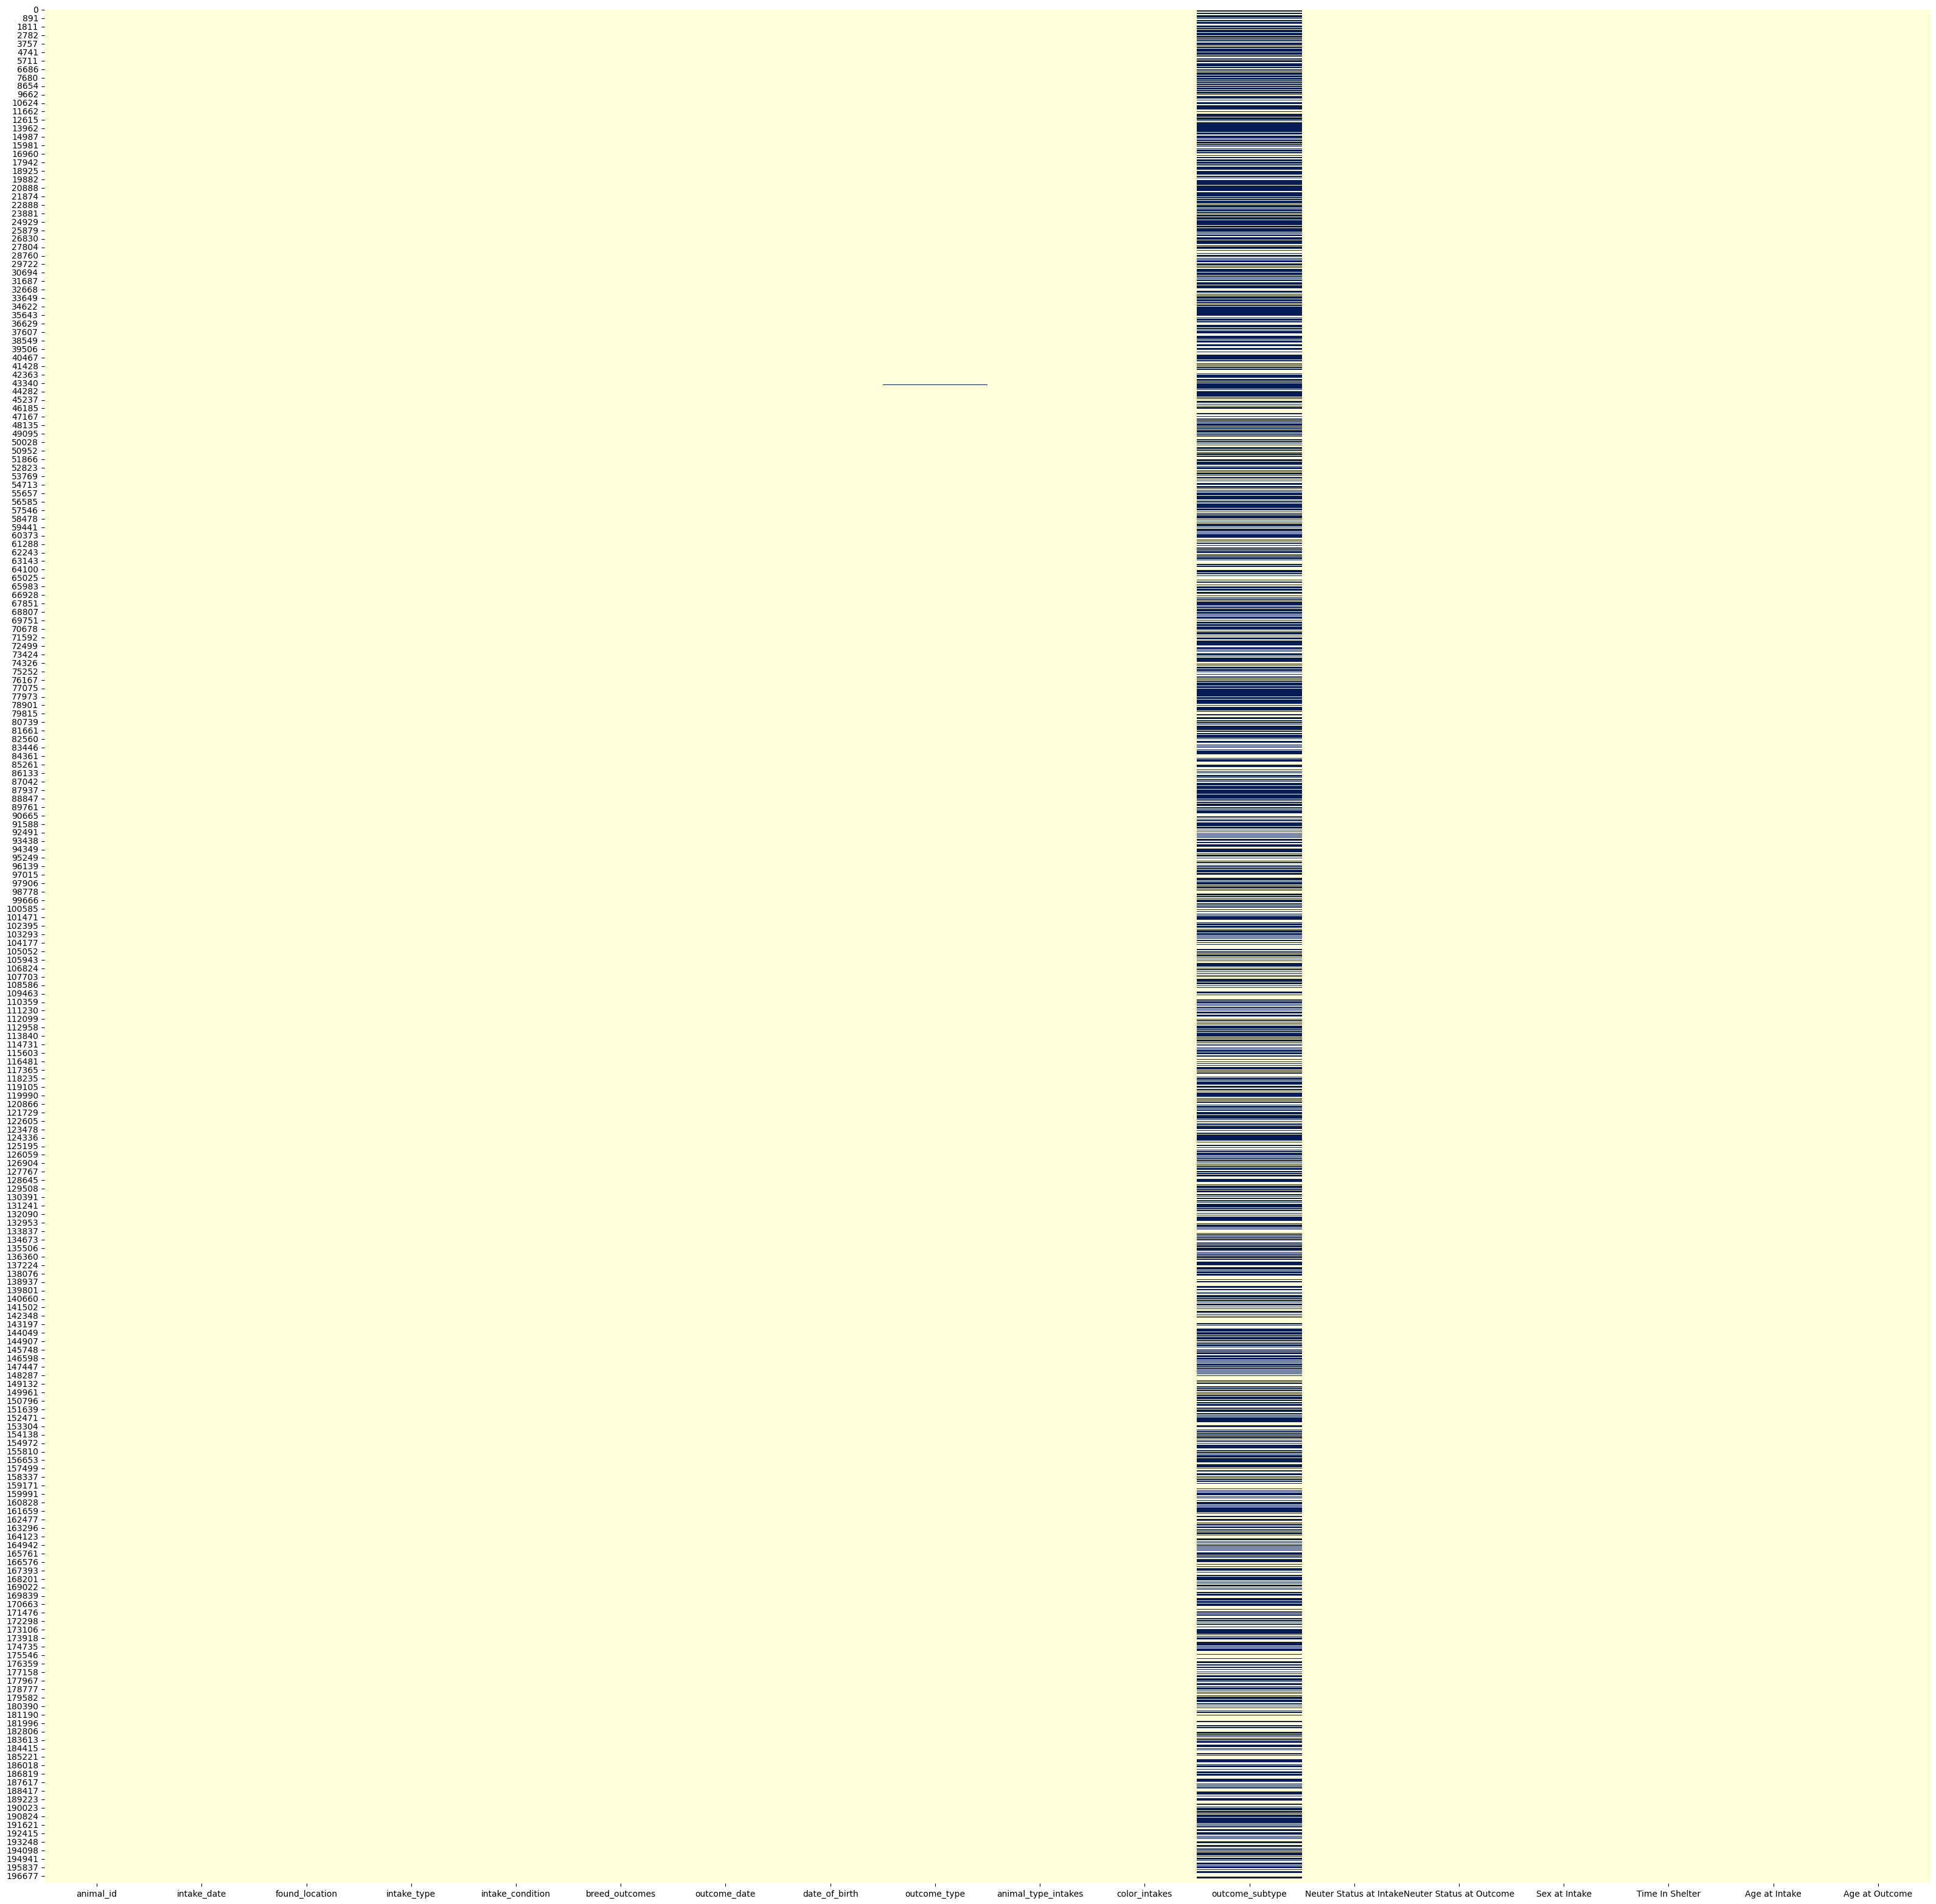

In [40]:
# generate a heatmap of missing values using matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40,40))
sns.heatmap(shelter_df.isnull(), cbar=False, cmap="YlGnBu")
plt.show()

The heatmap suggests that missing values are concentrated in the outcome_subtype column, but there are also some missing values in the outcome_type column. We look more closely at the numbers of missing values in the two columns using the .isna() and .sum() method.

In [44]:
# check for non-null values
null_val_shelter = shelter_df.isnull().sum()
null_val_shelter

animal_id                       0
intake_date                     0
found_location                  0
intake_type                     0
intake_condition                0
breed_outcomes                  0
outcome_date                    0
date_of_birth                   0
outcome_type                   36
animal_type_intakes             0
color_intakes                   0
outcome_subtype             99352
Neuter Status at Intake         0
Neuter Status at Outcome        0
Sex at Intake                   0
Time In Shelter                 0
Age at Intake                   0
Age at Outcome                  0
dtype: int64

In [46]:
# checking how many rows have null values in outcome_type columns:
rows_with_nulls = shelter_df[shelter_df['outcome_type'].isnull()].any(axis=1)
null_rows_count = rows_with_nulls.sum()
null_rows_count

36

outcome_type is a very important column for our analysis, and for this reason, we choose to delete the 36 rows that have null values in this column.

In [ ]:
# delete the rows that have missing values for outcome_type
shelter_df.dropna(subset=['outcome_type'], inplace=True)

We explore the outcome_subtype data to determine its relevance and usefulness to our analysis. First we replace all null values with "Not specified", then we aggregate the data to see what we can learn.

In [ ]:
# replace null values for outcome_subtype with "Not specified"
shelter_df["outcome_subtype"] = shelter_df["outcome_subtype"].fillna("Not specified")

In [ ]:
# aggregate the data
shelter_df.groupby(["outcome_type", "outcome_subtype"])["outcome_subtype"].count()

outcome_type     outcome_subtype    
Adoption         Barn                       3
                 Foster                 16061
                 Not specified          65295
                 Offsite                  535
Died             At Vet                    99
                 Emergency                 16
                 Enroute                   94
                 In Foster                339
                 In Kennel                743
                 In Surgery                31
                 Not specified            115
Disposal         Not specified            693
                 Rabies Risk               22
Euthanasia       Aggressive               771
                 At Vet                   204
                 Behavior                 189
                 Court/Investigation       97
                 Medical                  349
                 Not specified            270
                 Rabies Risk             4410
                 Suffering               38

PLACEHOLDER TO DEVELOP BAR CHART THAT SHOWS SUBTYPES FOR ANIMALS WHO WHERE EUTHANIZED AND TO JUSTIFY WHY WE ARE NOT KEEPING SUBTYPE (IF THAT IS WHAT WE DECIDE TO DO!) NOTE: WE MAY NEED TO CLEAN SOME OF THE SUBTYPES
### This barchart illustrates outcome subtypes for animals who were euthanised and whose outcome was not specified:

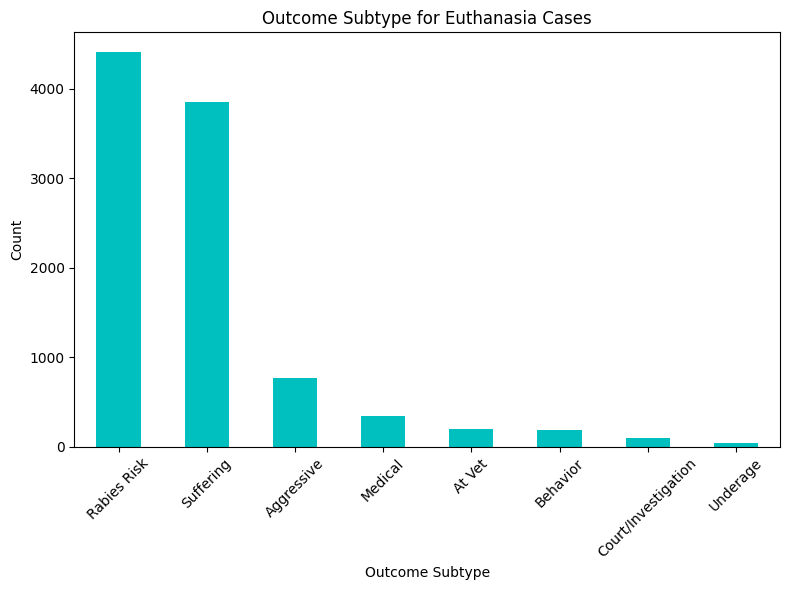

In [56]:
# Filter the df to select only 'Euthanasia' outcomes:
euthanasia_df = shelter_df[shelter_df['outcome_type'] == 'Euthanasia']

# Count the occurrences of each outcome_subtype for Euthanasia cases
outcome_subtype_counts = euthanasia_df['outcome_subtype'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
outcome_subtype_counts.plot(kind='bar', color='c')

plt.title('Outcome Subtype for Euthanasia Cases')
plt.xlabel('Outcome Subtype')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

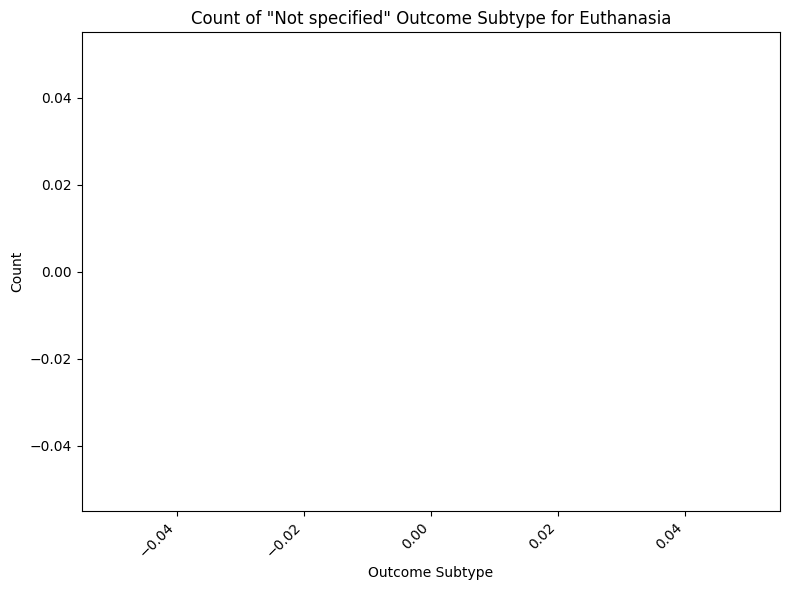

In [59]:
# Filter data for 'Euthanasia' outcome_type and 'Not specified' outcome_subtype
euthanasia_filtered_df = shelter_df[(shelter_df['outcome_type'] == 'Euthanasia') & (shelter_df['outcome_subtype'] == 'Not specified')]

# Count 'Not specified' outcome_subtype values
outcome_subtype_counts = euthanasia_filtered_df['outcome_subtype'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(outcome_subtype_counts.index, outcome_subtype_counts.values, color='blue')
plt.xlabel('Outcome Subtype')
plt.ylabel('Count')
plt.title('Count of "Not specified" Outcome Subtype for Euthanasia')
plt.xticks(rotation=45, ha='right')

# Display the chart
plt.tight_layout()
plt.show()

In [60]:
# lets quickly check what column names our dataframe currently has:
column_names = shelter_df.columns

for column_name in column_names:
    print(column_name)

animal_id
intake_date
found_location
intake_type
intake_condition
breed_outcomes
outcome_date
date_of_birth
outcome_type
animal_type_intakes
color_intakes
outcome_subtype
Neuter Status at Intake
Neuter Status at Outcome
Sex at Intake
Time In Shelter
Age at Intake
Age at Outcome


## Some final cleaning steps for readability and ease of use

### Changing column names

To improve readability of the data, we rename the columns.

In [61]:
# show all column names
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174286 entries, 0 to 197432
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   animal_id                 174286 non-null  int64          
 1   intake_date               174286 non-null  datetime64[ns] 
 2   found_location            174286 non-null  object         
 3   intake_type               174286 non-null  object         
 4   intake_condition          174286 non-null  object         
 5   breed_outcomes            174286 non-null  object         
 6   outcome_date              174286 non-null  datetime64[ns] 
 7   date_of_birth             174286 non-null  datetime64[ns] 
 8   outcome_type              174250 non-null  object         
 9   animal_type_intakes       174286 non-null  object         
 10  color_intakes             174286 non-null  object         
 11  outcome_subtype           74934 non-null   object   

In [62]:
# change column names to improve readability
shelter_df.rename(columns={'animal_id':'Animal ID',
                           'intake_date': 'Intake Date',
                           'found_location': 'Found Location',
                           'intake_type': 'Intake Type',
                           'intake_condition': 'Intake Condition',
                           'breed_outcomes':'Breed',
                           'outcome_date': 'Outcome Date',
                           'date_of_birth': 'Date of Birth',
                           'outcome_type': 'Outcome Type',
                           'animal_type_intakes': 'Animal',
                           'color_intakes': 'Colour',
                           'outcome_subtype': 'Outcome Subtype',
                           'Sex at Intake': 'Sex'},
                  inplace=True)

shelter_df.head(3)

,Animal ID,Intake Date,Found Location,Intake Type,Intake Condition,Breed,Outcome Date,Date of Birth,Outcome Type,Animal,Colour,Outcome Subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex,Time In Shelter,Age at Intake,Age at Outcome
0,665644,2013-10-21 07:59:00,Austin (TX),Stray,Sick,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21,Transfer,Cat,Calico,Partner,Intact,Intact,Female,0 days 03:40:00,30 days 07:59:00,30 days 11:39:00
1,665739,2013-10-22 11:11:00,Austin (TX),Stray,Normal,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16,Adoption,Cat,Black,Foster,Intact,Spayed,Female,59 days 06:25:00,36 days 11:11:00,95 days 17:36:00
2,665763,2013-10-22 15:10:00,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22,Adoption,Dog,Tan/White,NaN,Intact,Neutered,Male,4 days 03:22:00,122 days 15:10:00,126 days 18:32:00


### Sorting rows

We sort the rows based on the intake date and reset the index as the old index is not needed.

In [63]:
# sort by Intake Date
shelter_df.sort_values('Intake Date', inplace=True)

# reset index
shelter_df.reset_index(drop=True, inplace=True)

shelter_df.head(5)

,Animal ID,Intake Date,Found Location,Intake Type,Intake Condition,Breed,Outcome Date,Date of Birth,Outcome Type,Animal,Colour,Outcome Subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex,Time In Shelter,Age at Intake,Age at Outcome
0,521520,2013-10-01 07:51:00,Norht Ec in Austin (TX),Stray,Normal,Border Terrier/Border Collie,2013-10-01 15:39:00,2006-09-07,Return to Owner,Dog,White/Tan,NaN,Spayed,Spayed,Female,0 days 07:48:00,2581 days 07:51:00,2581 days 15:39:00
1,664236,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Domestic Shorthair Mix,2013-10-01 10:44:00,2013-09-24,Transfer,Cat,Orange/White,Partner,Unknown,Unknown,Unknown,0 days 02:11:00,7 days 08:33:00,7 days 10:44:00
2,664237,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Domestic Shorthair Mix,2013-10-01 10:44:00,2013-09-24,Transfer,Cat,Orange/White,Partner,Unknown,Unknown,Unknown,0 days 02:11:00,7 days 08:33:00,7 days 10:44:00
3,664235,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Domestic Shorthair Mix,2013-10-01 10:39:00,2013-09-24,Transfer,Cat,Orange/White,Partner,Unknown,Unknown,Unknown,0 days 02:06:00,7 days 08:33:00,7 days 10:39:00
4,664233,2013-10-01 08:53:00,7405 Springtime in Austin (TX),Stray,Injured,Pit Bull Mix,2013-10-01 15:33:00,2010-09-30,Euthanasia,Dog,Blue/White,Suffering,Intact,Intact,Female,0 days 06:40:00,1097 days 08:53:00,1097 days 15:33:00


# Potential Duplicates in data

When looking at the data above, we had noticed for rows 1-3, it included the same data but only animal id was different.
We then used the below code to check if there were any more rows in the data like this and saw that there was around 3000 rows.

When looking further into this, we had noticed that the majority Intake Age were for animals of a young age which could mean that the animals were brought to the shelter within the same litter tray. Therefore we did not remove these rows from our data as there is no certainty that the rows are duplicates

In [ ]:
shelter_df[shelter_df.duplicated(subset=shelter_df.columns.difference(['Animal ID']))]

,Animal ID,Intake Date,Found Location,Intake Type,Intake Condition,Breed,Outcome Date,Date of Birth,Outcome Type,Animal,Colour,Outcome Subtype,Neuter Status at Intake,Neuter Status at Outcome,Sex,Time In Shelter,Age at Intake,Age at Outcome
2,664237,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Domestic Shorthair Mix,2013-10-01 10:44:00,2013-09-24,Transfer,Cat,Orange/White,Partner,Unknown,Unknown,Unknown,0 days 02:11:00,7 days 08:33:00,7 days 10:44:00
211,664501,2013-10-04 12:08:00,Deidra Drive in Travis (TX),Stray,Normal,Domestic Shorthair Mix,2013-10-10 18:17:00,2013-07-20,Adoption,Cat,Black/White,Not specified,Intact,Neutered,Male,6 days 06:09:00,76 days 12:08:00,82 days 18:17:00
267,664369,2013-10-05 13:13:00,Del Valle (TX),Public Assist,Normal,Labrador Retriever/German Shepherd,2013-10-12 18:00:00,2013-05-27,Return to Owner,Dog,Black,Not specified,Intact,Neutered,Male,7 days 04:47:00,131 days 13:13:00,138 days 18:00:00
614,664958,2013-10-11 15:21:00,Davis/Brodie in Austin (TX),Stray,Normal,Labrador Retriever Mix,2013-10-14 17:06:00,2013-08-11,Transfer,Dog,Black/White,Partner,Intact,Intact,Female,3 days 01:45:00,61 days 15:21:00,64 days 17:06:00
693,665042,2013-10-12 18:39:00,1801 Fort View in Austin (TX),Stray,Normal,Domestic Shorthair Mix,2013-10-12 19:24:00,2013-09-20,Transfer,Cat,Orange Tabby,Partner,Intact,Intact,Male,0 days 00:45:00,22 days 18:39:00,22 days 19:24:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174165,885996,2023-07-28 16:45:00,9609 Night Start Dr in Travis (TX),Stray,Normal,Domestic Shorthair,2023-08-01 16:26:00,2023-06-19,Transfer,Cat,Brown Tabby,Partner,Intact,Intact,Female,3 days 23:41:00,39 days 16:45:00,43 days 16:26:00
174166,885995,2023-07-28 16:45:00,9609 Night Start Dr in Travis (TX),Stray,Normal,Domestic Shorthair,2023-08-01 16:26:00,2023-06-19,Transfer,Cat,Brown Tabby,Partner,Intact,Intact,Female,3 days 23:41:00,39 days 16:45:00,43 days 16:26:00
174177,886050,2023-07-29 15:23:00,6904 Pondsdale Ln in Austin (TX),Stray,Normal,Domestic Shorthair,2023-07-29 17:19:00,2023-07-15,Transfer,Cat,Black,Partner,Intact,Intact,Male,0 days 01:56:00,14 days 15:23:00,14 days 17:19:00
174180,886048,2023-07-29 15:23:00,6904 Pondsdale Ln in Austin (TX),Stray,Normal,Domestic Shorthair,2023-07-29 17:18:00,2023-07-15,Transfer,Cat,Brown Tabby,Partner,Intact,Intact,Male,0 days 01:55:00,14 days 15:23:00,14 days 17:18:00


### Rearranging column postions

We rearrange the column positions for easier readability of the data.

In [64]:
shelter_df = shelter_df.reindex(columns=['Animal ID',
                                         'Found Location',
                                         'Animal',
                                         'Date of Birth',
                                         'Intake Date',
                                         'Outcome Date',
                                         'Time In Shelter',
                                         'Age at Intake',
                                         'Age at Outcome',
                                         'Intake Condition',
                                         'Intake Type',
                                         'Outcome Type',
                                         'Outcome Subtype',
                                         'Sex',
                                         'Neuter Status at Intake',
                                         'Neuter Status at Outcome',
                                         'Breed',
                                         'Colour'])





shelter_df

,Animal ID,Found Location,Animal,Date of Birth,Intake Date,Outcome Date,Time In Shelter,Age at Intake,Age at Outcome,Intake Condition,Intake Type,Outcome Type,Outcome Subtype,Sex,Neuter Status at Intake,Neuter Status at Outcome,Breed,Colour
0,521520,Norht Ec in Austin (TX),Dog,2006-09-07,2013-10-01 07:51:00,2013-10-01 15:39:00,0 days 07:48:00,2581 days 07:51:00,2581 days 15:39:00,Normal,Stray,Return to Owner,NaN,Female,Spayed,Spayed,Border Terrier/Border Collie,White/Tan
1,664236,Abia in Austin (TX),Cat,2013-09-24,2013-10-01 08:33:00,2013-10-01 10:44:00,0 days 02:11:00,7 days 08:33:00,7 days 10:44:00,Normal,Stray,Transfer,Partner,Unknown,Unknown,Unknown,Domestic Shorthair Mix,Orange/White
2,664237,Abia in Austin (TX),Cat,2013-09-24,2013-10-01 08:33:00,2013-10-01 10:44:00,0 days 02:11:00,7 days 08:33:00,7 days 10:44:00,Normal,Stray,Transfer,Partner,Unknown,Unknown,Unknown,Domestic Shorthair Mix,Orange/White
3,664235,Abia in Austin (TX),Cat,2013-09-24,2013-10-01 08:33:00,2013-10-01 10:39:00,0 days 02:06:00,7 days 08:33:00,7 days 10:39:00,Normal,Stray,Transfer,Partner,Unknown,Unknown,Unknown,Domestic Shorthair Mix,Orange/White
4,664233,7405 Springtime in Austin (TX),Dog,2010-09-30,2013-10-01 08:53:00,2013-10-01 15:33:00,0 days 06:40:00,1097 days 08:53:00,1097 days 15:33:00,Injured,Stray,Euthanasia,Suffering,Female,Intact,Intact,Pit Bull Mix,Blue/White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174281,886460,Capital Of Texas Highway in Austin (TX),Dog,2022-08-06,2023-08-06 08:25:00,2023-08-06 13:25:00,0 days 05:00:00,365 days 08:25:00,365 days 13:25:00,Injured,Public Assist,Return to Owner,NaN,Male,Neutered,Neutered,Miniature Poodle Mix,Apricot
174282,886470,Travis (TX),Dog,2022-02-06,2023-08-06 10:28:00,2023-08-06 14:10:00,0 days 03:42:00,546 days 10:28:00,546 days 14:10:00,Normal,Public Assist,Return to Owner,NaN,Male,Intact,Intact,Standard Poodle/Labrador Retriever,Apricot/White
174283,886481,Outside Jurisdiction,Cat,2021-08-06,2023-08-06 13:46:00,2023-08-06 16:16:00,0 days 02:30:00,730 days 13:46:00,730 days 16:16:00,Injured,Stray,Transfer,Partner,Female,Intact,Intact,Domestic Shorthair,Brown Tabby
174284,886517,Furness Drive in Austin (TX),Dog,2023-05-30,2023-08-07 11:50:00,2023-08-07 17:59:00,0 days 06:09:00,69 days 11:50:00,69 days 17:59:00,Sick,Stray,Transfer,Partner,Female,Intact,Intact,German Shepherd Mix,Black/Brown


## Write cleaned data to csv file

In [65]:
# write cleaned data to csv
shelter_df.to_csv('Austin_Animal_Center_clean_data.csv')